In [1]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [40]:
# Para quitar los warnings de incopatibilidad con matplot
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# The Variational Quantum Eigensolver — Coding with Qiskit S2E4

In [41]:
import numpy as np 
import pylab
import copy
from qiskit import BasicAer
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.aqua.components.optimizers import SLSQP
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.drivers import PySCFDriver
from qiskit.chemistry.core import Hamiltonian, QubitMappingType

In [42]:
# Podemos variar la dimensión de las llaves -> Dirección Z
molecule = 'H .0 .0 -{0} ;  Li .0 .0 {0}'
distances = np.arange(0.5, 4.25, 0.25) # Unidad -> angstrom 
vqe_energies = []
hf_energies = []
exact_energies = []

In [43]:
for i, d in enumerate(distances): # Recorremos las distancias
    print('step', i) # Print statement para seguirle el paso al calculo
    # Set up experimente
    # Elegimos driver y le pasamos la mólecula 
    # y elegimos la base STO3G
    driver = PySCFDriver(molecule.format(d/2), basis='sto3g')
    # Quantum Molecule
    qmolecule = driver.run()
    # Crearmos el operador 
    # Codificamos la información usando la paridad
    operator = Hamiltonian( qubit_mapping=QubitMappingType.PARITY,
                          two_qubit_reduction= True, freeze_core=True, # hacemos una reducción de 2 qubits para acelerar el proceso
                        # y congelamos los electrones que no están involucrados
                          orbital_reduction=[-3, -2])# quitamos los orbitales que no contribuyen
    qubit_op, aux_ops = operator.run(qmolecule)
    
    # exact classical result
    exact_result = NumPyMinimumEigensolver(qubit_op, aux_operators=aux_ops).run()
    exact_result = operator.process_algorithm_result(exact_result)
    
    # VQE Section
    optimizer = SLSQP(maxiter = 1000)
    initial_state = HartreeFock(operator.molecule_info['num_orbitals'],
                                operator.molecule_info['num_particles'],
                                qubit_mapping=operator._qubit_mapping,
                                two_qubit_reduction=operator._two_qubit_reduction)
    var_form = UCCSD(num_orbitals = operator.molecule_info['num_orbitals'],
                    num_particles = operator.molecule_info['num_particles'],
                    initial_state = initial_state,
                    qubit_mapping = operator._qubit_mapping,
                    two_qubit_reduction = operator._two_qubit_reduction)
    
    algo = VQE(qubit_op, var_form, optimizer, aux_operators=aux_ops)
    
    vqe_result = algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator')))
    vqe_result = operator.process_algorithm_result(vqe_result)
    
    exact_energies.append(exact_result.energy)
    vqe_energies.append(vqe_result.energy)
    hf_energies.append(vqe_result.hartree_fock_energy)

step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14


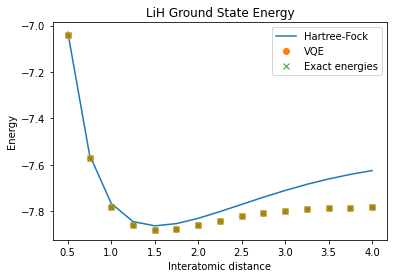

In [45]:
pylab.plot(distances, hf_energies, label='Hartree-Fock')
pylab.plot(distances, vqe_energies, 'o', label='VQE')
pylab.plot(distances, exact_energies, 'x', label='Exact energies')

pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('LiH Ground State Energy')
pylab.legend(loc='upper right')

---